# User-Based Collaborative Filtering Test
### Katelyn Stringer, April 14, 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import predict_full, train_test_split, mse
import time
%matplotlib inline

### Read in and format the data

In [2]:
ratings = pd.read_csv('data/ratings.csv',header=0)
ratings.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [3]:
### Sort the values
ratings.sort_values('userId',inplace=True)
print(len(ratings))

100004


We see that the format of this data is a row per rating with 4 columns. We need to reshape this into a useful matrix format to build our recommendation engine. We can use pivot for this.

In [4]:
ratings = ratings.pivot_table(index='movieId',columns='userId',values='rating')
ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate similarity between users

Now we have a really sparse matrix indexed by movieId, filled with all of the ratings values for each user (columns). Since we set the users as columns, we can use pandas' "corr" function to determine the correlation between different users.

In [5]:
sim = ratings.corr()
sim.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.068752,NaN,NaN,-0.912871,NaN,NaN,NaN,...,NaN,NaN,1.000000,0.132453,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.000000,0.000000,-0.070244,0.283473,NaN,0.302032,-0.044901,0.000000,-1.000000,...,-0.042903,-1.0,0.296117,-0.368922,0.052083,-0.224189,-0.500000,-1.000000,-0.648204,0.460239
3,NaN,0.000000,1.000000,NaN,-0.170881,-1.000000,0.188056,0.061023,-0.580948,0.559017,...,0.143420,NaN,0.506024,0.114808,0.655596,0.699260,-0.693375,0.970725,-0.218218,0.354044
4,0.068752,-0.070244,NaN,1.000000,0.084827,0.434057,0.270274,0.471954,NaN,NaN,...,0.179664,NaN,0.181856,0.356573,0.254491,0.600736,0.577350,0.270765,0.027639,0.131904
5,NaN,0.283473,-0.170881,0.084827,1.000000,0.333333,-0.559017,-0.181601,0.261116,1.000000,...,0.389156,NaN,0.002655,0.180346,-0.369175,-0.408248,NaN,NaN,-0.632456,-0.186872


This returned a 671x671 matrix showing how the different users are correlated to each other. Note all of the NaN's where there were insufficient overlapping ratings for the same movies to calculate the correlations.

### Predict movie ratings for one user

Now let's try to fill in some of the missing values for each user based on the similarity to other users. First, we extract the first user and the similarity values.

In [6]:
user1 = ratings[1]
print(user1.head())

### Locate all movies that this user rated and ignore nans.
moviesrated = np.unique(user1[user1.values>0].index)
print(len(user1),len(moviesrated))
print(moviesrated[:5])

movieId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: 1, dtype: float64
9066 20
[  31 1029 1061 1129 1172]


C:\Users\hooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [7]:
### Pull out the rows for the movies not rated by user 1.
unknown_movies = ratings[~ratings.index.isin(moviesrated)]
print(unknown_movies.head())
print(len(unknown_movies))

userId   1    2    3    4    5    6    7    8    9    10  ...   662  663  664  \
movieId                                                   ...                   
1        NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  NaN ...   NaN  4.0  3.5   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   5.0  NaN  NaN   
3        NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   

userId   665  666  667  668  669  670  671  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  4.0  5.0  
2        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
3        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 671 columns]
9046


In [8]:
### Pull out similarities to other users for this one user
tempsim = sim.iloc[0]
tempsim.head()

userId
1    1.000000
2         NaN
3         NaN
4    0.068752
5         NaN
Name: 1, dtype: float64

In [9]:
### Multiply these movies by the weights from other users
temp_weights = np.transpose(tempsim)*unknown_movies
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
### Sum up all of the weights for each row
temp_weights['sum'] = temp_weights.sum(axis=1)
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,sum
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.969611
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-4.782301
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,12.136257
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.919123
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-3.459428


In [11]:
### Make a mask of NaNs to apply to sim matrix
nanmask = np.isfinite(temp_weights)*1
nansim = np.transpose(tempsim)*nanmask
print(nansim.head())

### Notice that the Nan values now do not have a similarity weight.

userId     1   2   3    4   5   6         7   8   9  10 ...   663  664  \
movieId                                                 ...              
1        0.0 NaN NaN  0.0 NaN NaN -0.912871 NaN NaN NaN ...   NaN  1.0   
2        0.0 NaN NaN  0.0 NaN NaN -0.000000 NaN NaN NaN ...   NaN  0.0   
3        0.0 NaN NaN  0.0 NaN NaN -0.000000 NaN NaN NaN ...   NaN  0.0   
4        0.0 NaN NaN  0.0 NaN NaN -0.000000 NaN NaN NaN ...   NaN  0.0   
5        0.0 NaN NaN  0.0 NaN NaN -0.000000 NaN NaN NaN ...   NaN  0.0   

userId        665  666  667  668  669  670  671  sum  
movieId                                               
1        0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2        0.132453  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3        0.132453  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4        0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        0.132453  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 672 columns]


C:\Users\hooja\Anaconda3\lib\site-packages\pandas\indexes\base.py:2683: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


In [12]:
### Tack on weights to end of movie matrix
temp_weights['sumweights'] = nansim.sum(axis=1)
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,664,665,666,667,668,669,670,671,sum,sumweights
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.969611,1.194460
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-4.782301,-0.483368
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,12.136257,2.562949
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.919123,-0.305628
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-3.459428,-0.945392


In [15]:
### Estimate the ratings for this user and record the sample size of the estimate (larger numbers means better statistics)
temp_weights['pred'] = [float(a)/b for a,b in zip(temp_weights['sum'],temp_weights['sumweights'])]
temp_weights['pred'].head()
temp_weights['size'] = temp_weights.count(axis=1) ## counts the number of non-Nan values in a row

C:\Users\hooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\hooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [16]:
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,666,667,668,669,670,671,sum,sumweights,pred,size
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.969611,1.194460,7.509343,76
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.782301,-0.483368,9.893717,38
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.136257,2.562949,4.735270,24
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.919123,-0.305628,6.279283,8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-3.459428,-0.945392,3.659251,19


Let's get rid of any crazy values. Clearly, if the value is below zero, we can assume the rating would be zero in real life on the 0-5 scale. The same goes for values above 5.

In [35]:
### Set negative values to zero
temp_weights['pred'].loc[temp_weights['pred']<0]=0
### Set large positive values to 5
temp_weights['pred'].loc[temp_weights['pred']>5]=5

C:\Users\hooja\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(array([ 0.11250158,  0.04651751,  0.07306282,  0.09531033,  0.16306409,
         0.2318291 ,  0.32183036,  0.30084692,  0.31020099,  0.3448363 ]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 1 Patch objects>)

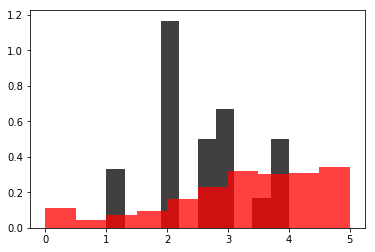

In [43]:
### Take a look at the ratings compared to the ones the user already had
plt.hist(user1.dropna(),color='black',histtype='stepfilled',normed=True,bins=10,alpha=0.75)
plt.hist(temp_weights['pred'].dropna(),color='red',histtype='stepfilled',normed=True,bins=10,alpha=0.75)

It is unfortunate that this user rated so sparsely as it looks like the recommendation system skewed recommendations far more postively than the user actually rated movies in real life. Now that we understand how the nuts and bolts of this work, let's test this on a larger scale using the functions in utils.py

## Test on a wider scale

In [5]:
### First, let's split the data into a training and test set
### To be consistent with the notation of my partner, I need to switch the row and column placement
ratings_filled = ratings.transpose()
ratings_filled.fillna(0,inplace=True)### We need to fill the nans with zeros for matrix multiplication
train, test = train_test_split(ratings_filled, empty=0.0, testfrac=0.2)

In [6]:
### Check that ~80% of the ratings are in the training set per movie
(train.astype(bool).sum(axis=1)/ratings_filled.astype(bool).sum(axis=1)).head(n=7)

userId
1    0.800000
2    0.802632
3    0.803922
4    0.803922
5    0.800000
6    0.818182
7    0.806818
dtype: float64

In [7]:
### Find the similarity matrix for our training data
st = time.time()
sim_train = train.transpose().corr() ### pandas corr finds correlation for columns not rows
print('Time to calculate similarity:',time.time()-st)

Time to calculate similarity: 12.389978647232056


In [9]:
### Use the similarity matrix to predict movie ratings
st = time.time()
prediction = predict_full(train, sim_train.transpose().values)
print('Time to train:',time.time()-st)

Time to train: 0.21457147598266602


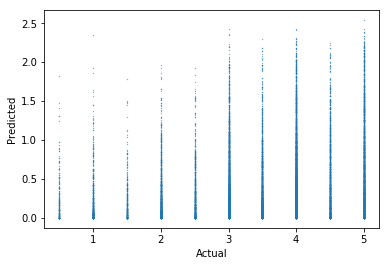

In [10]:
### Let's check this to see how we did
plt.plot(test.values[test.values > 0], prediction.values[test.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [11]:
### So this looks pretty bad. Let's quantify how bad
mse(pred=prediction, actual=test)

10.866748110811818

Actually, this is fairly comparable to our other cosine similarity metric.